In [6]:
import sys
import tyssue
import random
import numpy as np
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
import ipyvolume as ipv
from matplotlib import pyplot
from tyssue.solvers import QSSolver

from IPython.display import Image


from tyssue.topology import add_vert


from tyssue import config, Sheet, SheetGeometry, History, EventManager, PlanarGeometry
from tyssue import SheetGeometry as geom
from tyssue import PlanarGeometry as geom
from tyssue.draw.plt_draw import create_gif
from tyssue.draw.plt_draw import plot_forces
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import PlanarModel
from tyssue.dynamics import SheetModel as model
from tyssue.generation import three_faces_sheet
from tyssue.solvers.viscous import EulerSolver
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5
import copy

from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model


from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division

import warnings
warnings.filterwarnings('ignore')

### T1 transitions

from tyssue.topology.sheet_topology import type1_transition
from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split
from tyssue.topology import condition_4i, condition_4ii

collision solver could not be imported You may need to install CGAL and re-install tyssue
C++ extension are not available for this version


In [7]:
def length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity):
    
    cellmap.edge_df['length_elasticity_ECM'] = cellmap.edge_df['length_elasticity']
    cellmap.edge_df['length_elasticity_FRC'] = cellmap.edge_df['length_elasticity']
        
    for edge in range(len(cellmap.edge_df)):
        FRC = random.randrange(FRC_lower_length_elasticity, FRC_higher_length_elasticity)/10000
        ECM = random.randrange(ECM_lower_length_elasticity, ECM_higher_length_elasticity)/10000
        cellmap.edge_df['length_elasticity'][edge] = FRC + ECM
        cellmap.edge_df['length_elasticity_ECM'][edge] = ECM
        cellmap.edge_df['length_elasticity_FRC'][edge] = FRC
    return cellmap

In [8]:
def prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area):
    for face in range(len(cellmap.face_df)):
        newValue = random.randrange(lower_prefered_area, higher_prefered_area)/10000
        cellmap.face_df['prefered_area'][face] = newValue
    return cellmap

In [9]:
def change_specs(cellmap, geom, model, history, area_elasticity,
                 lower_prefered_area, higher_prefered_area, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity,
                 ECM_higher_length_elasticity, line_nought):
    
    
    length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity)
    prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area)
    
    cellmap.face_df["area_elasticity"] = area_elasticity
    cellmap.edge_df["prefered_length"] = line_nought


    cellmap.vert_df["viscosity"] = 1   
    
    #cellmap_original.face_df["prefered_area"][0] = 2
    #cellmap_original.face_df["prefered_area"][41] = 2

    
    solver = QSSolver()
    res = solver.find_energy_min(cellmap, geom, model)

    fig, ax = sheet_view(cellmap, mode="quick")
    fig.set_size_inches(10, 10)
    

        

    
    cellmap_new = copy.deepcopy(cellmap_original)
    geom_new = copy.deepcopy(geom_original)
    model_new = copy.deepcopy(model_original)
    history_new = copy.deepcopy(history_original)
    
    return [cellmap_new, geom_new, model_new, history_new]

In [10]:
def create_frames(
    history,
    output,
    movie_name,
    num_frames=None,
    interval=None,
    draw_func=None,
    margin=5,
    **draw_kwds,
):
    """Creates a set of png frames of the recorded history.
   
    Parameters
    ----------
    history : a :class:`tyssue.History` object
    output : path to the output directory
    num_frames : int, the number of frames in the gif
    interval : tuples, define begin and end frame of the gif
    draw_func : a drawing function
         this function must take a `sheet` object as first argument
         and return a `fig, ax` pair. Defaults to quick_edge_draw
         (aka sheet_view with quick mode)
    margin : int, the graph margins in percents, default 5
         if margin is -1, let the draw function decide
    **draw_kwds are passed to the drawing function
    """
    if draw_func is None:
        draw_func = sheet_view

    graph_dir = Path(output + '/' + movie_name)
    graph_dir.mkdir(parents=True, exist_ok=True)

    x, y = coords = draw_kwds.get("coords", history.sheet.coords[:2])
    sheet0 = history.retrieve(0)
    bounds = sheet0.vert_df[coords].describe().loc[["min", "max"]]
    delta = (bounds.loc["max"] - bounds.loc["min"]).max()
    margin = delta * margin / 100
    xlim = bounds.loc["min", x] - margin, bounds.loc["max", x] + margin
    ylim = bounds.loc["min", y] - margin, bounds.loc["max", y] + margin

    if interval is None:
        start, stop = None, None
    else:
        start, stop = interval[0], interval[1]

    for i, (t, sheet) in enumerate(history.browse(start, stop, num_frames)):
        try:
            fig, ax = draw_func(sheet, **draw_kwds)
        except Exception as e:
            print("Droped frame {i}")

        if isinstance(ax, plt.Axes) and margin >= 0:
            ax.set(xlim=xlim, ylim=ylim)
        fig.savefig(graph_dir / f"movie_{i:04d}.png")
        plt.close(fig)

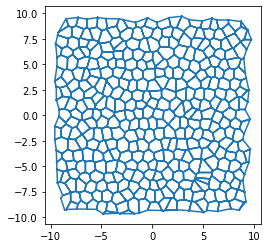

In [11]:
## Definition of the sheet

cellmap_original = Sheet.planar_sheet_2d('cellmap', 30, 30, 1, 1, noise = 0.2) # This may need to change
geom_original  = PlanarGeometry

to_cut = cellmap_original.cut_out([(-2, 20), (-2, 20)])
cellmap_original.remove(to_cut, trim_borders=True)

geom.center(cellmap_original)
geom.update_all(cellmap_original)
cellmap_original.update_rank()

model_original = model_factory([    
    effectors.FaceAreaElasticity,
    effectors.LengthElasticity
    ])

history_original = History(cellmap_original,
                           extra_cols={"edge":["dx", "dy"]})

cellmap_original.update_specs(model_original.specs)

fig, ax = sheet_view(cellmap_original, ['x', 'y'], mode='quick')

In [12]:
cellmap_original.face_df

,y,is_alive,perimeter,area,x,num_sides,id,area_elasticity,prefered_area
face,,,,,,,,,
0,-9.579874,1,3.013053,0.204166,-4.040230,4,0,1.0,1.0
1,-9.554661,1,2.972264,0.245639,-2.413283,3,0,1.0,1.0
2,-9.313836,1,2.709536,0.060624,1.804941,4,0,1.0,1.0
3,-8.911787,1,3.202143,0.595473,-7.793214,4,0,1.0,1.0
4,-8.850772,1,3.165666,0.623529,-6.913698,5,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
358,8.874722,1,3.674294,0.822830,5.221687,5,0,1.0,1.0
359,8.853158,1,3.342494,0.704600,6.092772,5,0,1.0,1.0
360,8.939608,1,3.535844,0.760499,6.919293,5,0,1.0,1.0


## Phase: Homeostasis

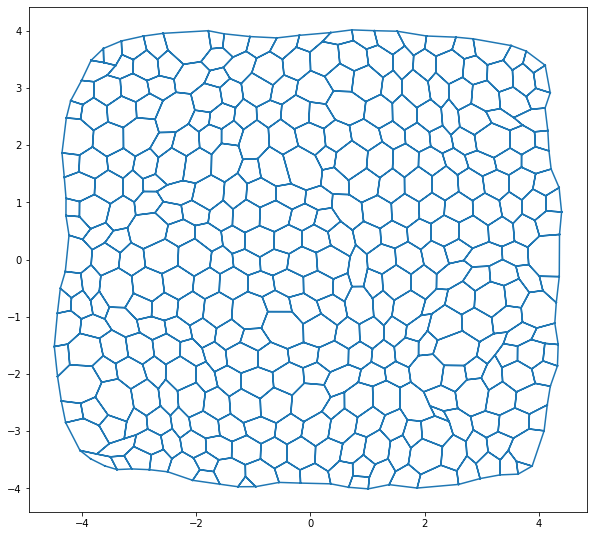

In [64]:
[cellmap_H, geom_H, model_H, history_H] = change_specs(cellmap_original, geom_original, model_original, history_original, area_elasticity = 0.5, lower_prefered_area = 1000, higher_prefered_area = 10000, 
                                                       FRC_lower_length_elasticity = 1000, FRC_higher_length_elasticity = 10000, ECM_lower_length_elasticity = 100, 
                                                       ECM_higher_length_elasticity = 1000, line_nought = 0.2)

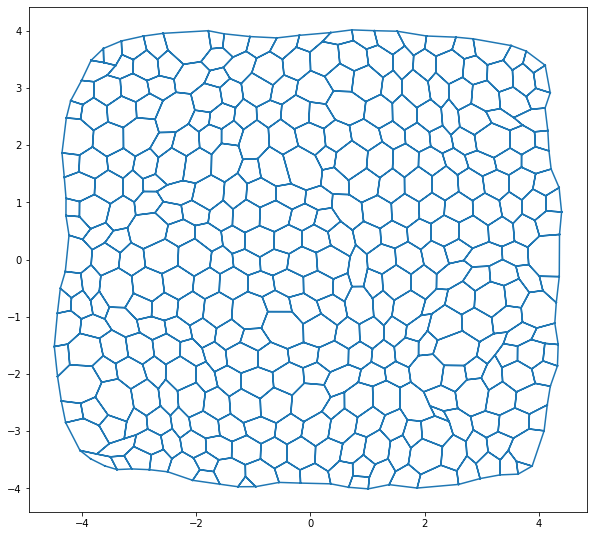

In [65]:
fig, ax = sheet_view(cellmap_H, mode="quick")
fig.set_size_inches(10, 10)
#plt.savefig('cellmap_homeostasis.png')

In [66]:
number_of_faces = len(cellmap_H.face_df)
mean_area_H = cellmap_H.face_df["area"].mean()
total_area_H = number_of_faces*mean_area_H
total_area_H

65.44880625311936

In [67]:
cellmap_H.edge_df["length_elasticity_FRC"]

edge
0       0.2713
1       0.5677
2       0.1509
3       0.3633
4       0.6616
         ...  
2097    0.6150
2098    0.7724
2099    0.9399
2100    0.5209
2101    0.3411
Name: length_elasticity_FRC, Length: 2102, dtype: float64

In [68]:
cellmap_H.edge_df["length_elasticity_ECM"]

edge
0       0.0903
1       0.0434
2       0.0247
3       0.0492
4       0.0465
         ...  
2097    0.0770
2098    0.0250
2099    0.0566
2100    0.0320
2101    0.0778
Name: length_elasticity_ECM, Length: 2102, dtype: float64

In [69]:
cellmap_H.edge_df["length_elasticity"]

edge
0       0.3616
1       0.6111
2       0.1756
3       0.4125
4       0.7081
         ...  
2097    0.6920
2098    0.7974
2099    0.9965
2100    0.5529
2101    0.4189
Name: length_elasticity, Length: 2102, dtype: float64

In [70]:
#fig, ax = sheet_view(cellmap_H, ['x', 'y'])
#fig.set_size_inches(15, 15)

#for face, data in cellmap_original.face_df.iterrows():
#    ax.text(data.y, data.x, face, fontsize=7, color="r")

(array([ 3.,  1.,  0.,  0.,  1.,  5.,  4.,  1.,  4.,  8.,  8., 10.,  8.,
        14., 14., 23., 23., 19., 19., 18., 19., 19., 15., 20., 18., 17.,
        15.,  9.,  4.,  9.,  5.,  3.,  3.,  5.,  1.,  2.,  2.,  2.,  2.,
         2.,  0.,  1.,  0.,  2.,  1.,  3.,  0.,  0.,  0.,  1.]),
 array([ 1.        ,  1.27603435,  1.55206871,  1.82810306,  2.10413741,
         2.38017176,  2.65620612,  2.93224047,  3.20827482,  3.48430918,
         3.76034353,  4.03637788,  4.31241224,  4.58844659,  4.86448094,
         5.14051529,  5.41654965,  5.692584  ,  5.96861835,  6.24465271,
         6.52068706,  6.79672141,  7.07275577,  7.34879012,  7.62482447,
         7.90085882,  8.17689318,  8.45292753,  8.72896188,  9.00499624,
         9.28103059,  9.55706494,  9.8330993 , 10.10913365, 10.385168  ,
        10.66120235, 10.93723671, 11.21327106, 11.48930541, 11.76533977,
        12.04137412, 12.31740847, 12.59344283, 12.86947718, 13.14551153,
        13.42154588, 13.69758024, 13.97361459, 14.24964894,

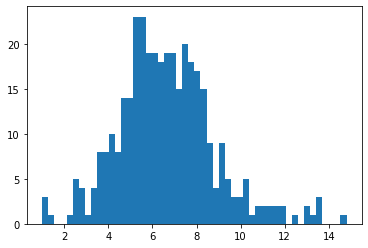

In [71]:
normalised_area_df = cellmap_H.face_df["area"] / min(cellmap_H.face_df["area"])
plt.hist(normalised_area_df, bins = 50)

In [72]:
#create_frames(history_H, '.', 'homeostasis', num_frames=100)

In [73]:
mean_area_H = cellmap_H.face_df["prefered_area"].mean()
mean_area_H

0.5513553719008264

In [74]:
cellmap_H.edge_df["length_elasticity_FRC"]

edge
0       0.2713
1       0.5677
2       0.1509
3       0.3633
4       0.6616
         ...  
2097    0.6150
2098    0.7724
2099    0.9399
2100    0.5209
2101    0.3411
Name: length_elasticity_FRC, Length: 2102, dtype: float64

## Phase: Expansion

In [75]:
endTime = 20

current_prefered_area = cellmap_H.face_df['prefered_area']
cellmap_H.update_specs(
{"face": {"prefered_area": 3*current_prefered_area + 2*mean_area_H}},
reset=True)

current_FRC_length_elasticity = cellmap_H.edge_df['length_elasticity_FRC']
cellmap_H.update_specs(
{"edge": {"length_elasticity_FRC": 0.1*current_FRC_length_elasticity}},
reset=True)

current_line_nought = cellmap_H.edge_df['prefered_length']
cellmap_H.update_specs(
{"edge": {"prefered_length": 1.4*current_line_nought}},
reset=True)

solver = QSSolver()
res = solver.find_energy_min(cellmap_H, geom_H, model_H)
    
    
cellmap_E = copy.deepcopy(cellmap_H)
geom_E = copy.deepcopy(geom_H)
model_E = copy.deepcopy(model_H)
history_E = copy.deepcopy(history_H)


#for i in range(endTime):
#    solver1 = QSSolver(with_collisions=False, with_t1=False, with_t3=False)
#    res1 = solver1.find_energy_min(cellmap_H, geom_H, model_H, options={"ftol": 1e-2})
#    geom_H.update_all(cellmap_H)
#    history_H.record(time_stamp = i)


Reseting column prefered_area of the face dataset with new specs
Reseting column length_elasticity_FRC of the edge dataset with new specs
Reseting column prefered_length of the edge dataset with new specs


In [76]:
cellmap_E.edge_df["length_elasticity_FRC"]

edge
0       0.02713
1       0.05677
2       0.01509
3       0.03633
4       0.06616
         ...   
2097    0.06150
2098    0.07724
2099    0.09399
2100    0.05209
2101    0.03411
Name: length_elasticity_FRC, Length: 2102, dtype: float64

1.7758262969298333


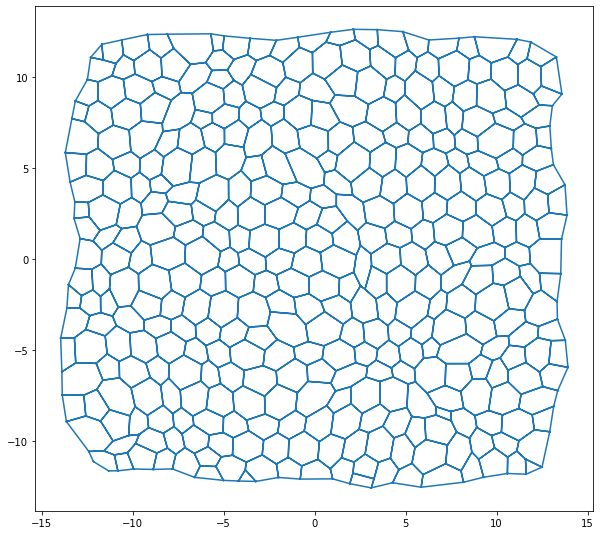

In [77]:
fig, ax = sheet_view(cellmap_E, mode="quick")
fig.set_size_inches(10, 10)

print(cellmap_E.face_df["area"].mean())
#plt.savefig('cellmap_uniform_expansion.png')

In [78]:
number_of_faces_E = len(cellmap_E.face_df)
mean_area_E = cellmap_E.face_df["area"].mean()
total_area_E = number_of_faces_E*mean_area_E
total_area_E

644.6249457855295

In [79]:
cellmap_E.face_df

,y,is_alive,perimeter,area,x,num_sides,id,area_elasticity,prefered_area
face,,,,,,,,,
0,-11.740831,1,4.021401,0.844605,-5.831025,4,0,0.5,2.641411
1,-12.007447,1,2.531651,0.296638,-3.742787,3,0,0.5,3.123811
2,-12.197843,1,3.529918,0.674447,2.603289,4,0,0.5,2.401411
3,-11.154413,1,3.458140,0.730901,-10.513820,4,0,0.5,2.624011
4,-10.917401,1,4.908173,1.617335,-9.523871,5,0,0.5,3.103111
...,...,...,...,...,...,...,...,...,...
358,11.600261,1,4.799600,1.394292,7.008458,5,0,0.5,2.142211
359,11.591808,1,4.020885,1.080957,8.416530,5,0,0.5,1.964911
360,11.467659,1,6.247315,2.265689,9.856990,5,0,0.5,3.546211


In [22]:
#fig, ax = sheet_view(cellmap_E, ['x', 'y'])
#fig.set_size_inches(10, 10)

#for face, data in cellmap_E.face_df.iterrows():
#    ax.text(data.y, data.x, face, fontsize=7, color="r")

In [23]:
#fig, ax = sheet_view(cellmap_E, ['x', 'y'])
#fig.set_size_inches(10, 10)

## Phase: T cell proliferation

In [24]:
# Make 40 of A_alphas grow a lot 

In [90]:
#choosing random 10 of Aalphas:

endTime = 10

ten_random_faces = cellmap_E.face_df.sample(10)
current_prefered_area = ten_random_faces["prefered_area"]
print(current_prefered_area)
ten_random_faces["prefered_area"]= 2.5*current_prefered_area
cellmap_E.face_df.loc[ten_random_faces.index, "prefered_area"] = ten_random_faces
geom_E.update_all(cellmap_E)

print(ten_random_faces["prefered_area"])

#geom.update_all(cellmap_E)


solver_T = QSSolver()
res_T = solver_T.find_energy_min(cellmap_E, geom_E, model_E)

#for i in range(endTime):
#    solver1 = QSSolver(with_collisions=False, with_t1=False, with_t3=False)
#    res1 = solver1.find_energy_min(cellmap_H, geom_H, model_H, options={"ftol": 1e-2})
#    geom_H.update_all(cellmap_H)
#    history_H.record(time_stamp = i)

cellmap_T = cellmap_E
geom_T = geom_E
model_T = model_E
history_T = history_E

face
129    2.016811
159    2.091211
3      2.624011
103    3.726811
220    3.463111
236    2.263411
124    4.004311
358    2.142211
68     5.035277
12     1.891111
Name: prefered_area, dtype: float64
face
129     5.042027
159     5.228027
3       6.560027
103     9.317027
220     8.657777
236     5.658527
124    10.010777
358     5.355527
68     12.588192
12      4.727777
Name: prefered_area, dtype: float64


1.9836967537582744

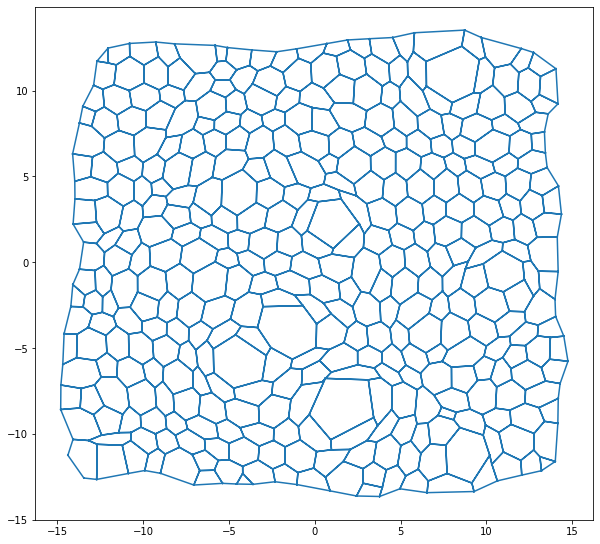

In [91]:
fig, ax = sheet_view(cellmap_T, mode="quick")

fig.set_size_inches(10, 10)
cellmap_T.face_df['area'].mean()
#plt.savefig('cellmap_T_cell_expansion.png')

In [92]:
cellmap_T.edge_df['length']


edge
0       1.075402
1       1.367318
2       1.367318
3       1.261674
4       1.261674
          ...   
2097    1.269489
2098    1.484545
2099    1.257724
2100    1.608019
2101    1.882904
Name: length, Length: 2102, dtype: float64

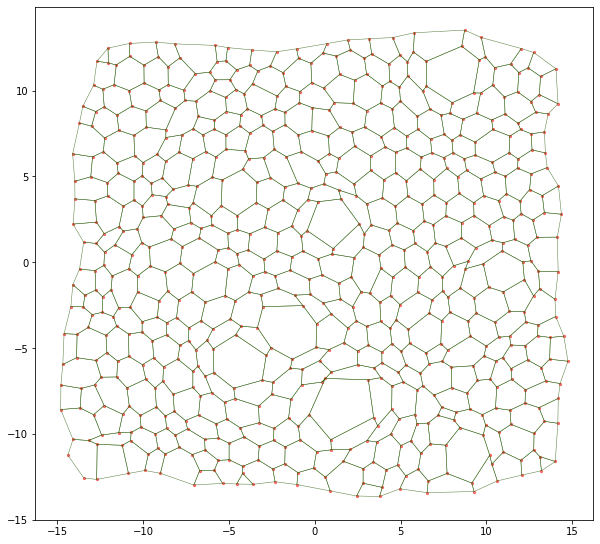

In [93]:
draw_specs = tyssue.config.draw.sheet_spec()

draw_specs['vert']['visible'] = True

draw_specs['vert']['color'] = "red"
draw_specs['vert']['alpha'] = 0.5
draw_specs['vert']['s'] = 5
coords = ['x', 'y']
fig, ax = sheet_view(cellmap_T, coords, **draw_specs)
fig.set_size_inches((10, 10))

In [94]:
cellmap_T.face_df

,y,is_alive,perimeter,area,x,num_sides,id,area_elasticity,prefered_area
face,,,,,,,,,
0,-12.526937,1,4.349390,1.022510,-6.240186,4,0,0.5,2.641411
1,-12.718937,1,2.542186,0.298049,-4.112513,3,0,0.5,3.123811
2,-13.313265,1,3.871450,0.818435,3.244117,4,0,0.5,2.401411
3,-11.555435,1,7.075259,3.079587,-11.861007,4,0,0.5,6.560027
4,-11.333681,1,5.477132,1.919947,-10.476682,5,0,0.5,3.103111
...,...,...,...,...,...,...,...,...,...
358,12.692894,1,8.183591,3.827185,7.071453,5,0,0.5,5.355527
359,12.595677,1,4.870188,1.427237,9.310675,5,0,0.5,1.964911
360,12.081642,1,6.451101,2.380989,10.717912,5,0,0.5,3.546211


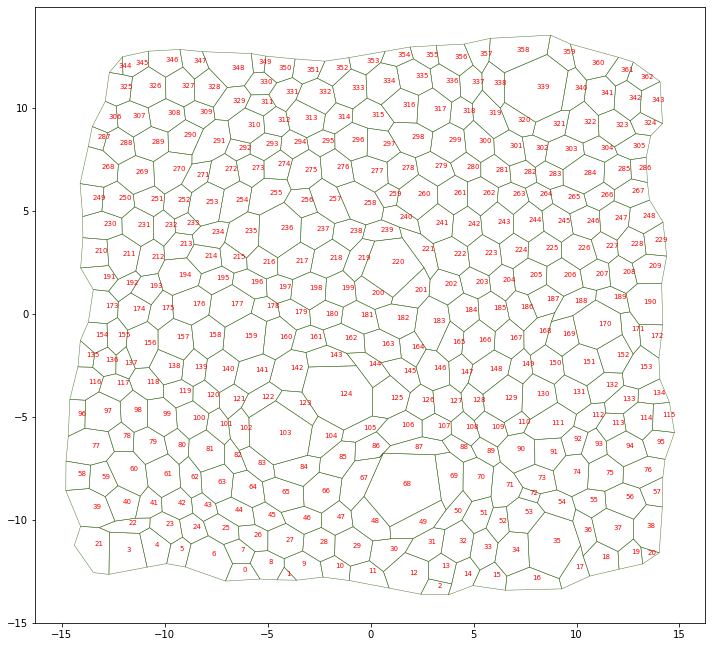

In [95]:
fig, ax = sheet_view(cellmap_T, ['x', 'y'])
fig.set_size_inches(12, 12)

for face, data in cellmap_T.face_df.iterrows():
    ax.text(data.x, data.y, face, fontsize=7, color="r")

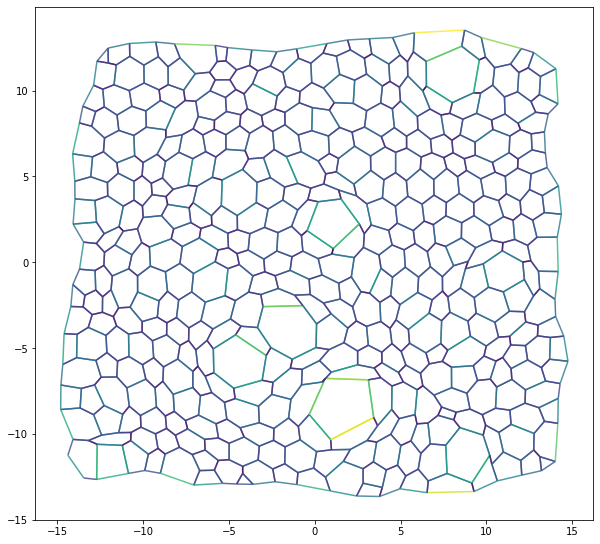

In [106]:
draw_specs['edge']['width'] = 1
color = cellmap_T.edge_df['length']
color[color<0] = 0;
ipv.clear()
fig2, mesh = sheet_view(cellmap_T, edge={"color":color, "width":1.5}, mode="2D")
fig2.set_size_inches(10, 10)



#plt.savefig('length_colour_T.png')

## Phase: V new vertices 

In [31]:
#forty_percent = round(0.4*len(cellmap_T.edge_df['length']))
#longest_forty_percent = cellmap_T.edge_df['length'].nlargest(n=forty_percent)
#edge_lim = longest_forty_percent.nsmallest(n=1)

In [32]:
#edge_lim

In [33]:
new_verts = np.empty((0, 3))
for numEdge in range(len(cellmap_T.edge_df)):
    currentEdge = cellmap_T.edge_df.loc[numEdge];
    if currentEdge['length']>2:
        new_vert = add_vert(cellmap_T, numEdge)
        new_verts = np.append(new_verts, [new_vert])
    

In [34]:
len(new_verts)

21

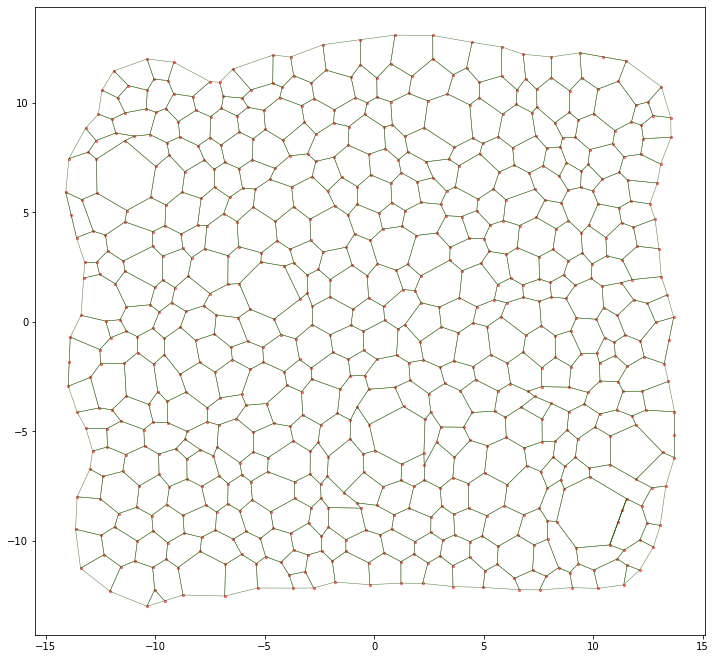

In [35]:
draw_specs = tyssue.config.draw.sheet_spec()

draw_specs['vert']['visible'] = True

draw_specs['vert']['color'] = "red"
draw_specs['vert']['alpha'] = 0.5
draw_specs['vert']['s'] = 5


coords = ['x', 'y']
fig, ax = sheet_view(cellmap_T, coords, **draw_specs)
fig.set_size_inches((12, 12))

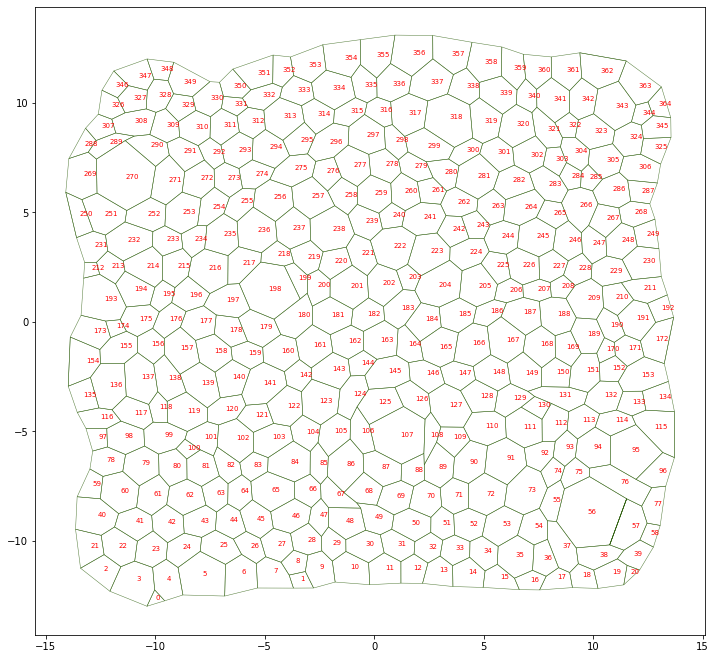

In [36]:
fig, ax = sheet_view(cellmap_T, ['x', 'y'])
fig.set_size_inches(12, 12)
for face, data in cellmap_T.face_df.iterrows():
    ax.text(data.x, data.y, face, fontsize=7, color="r")

In [37]:
ten_random_faces.index

Int64Index([95, 356, 107, 236, 318, 270, 198, 5, 60, 56], dtype='int64', name='face')

### Phase D: cell division

In [57]:
ten_random_faces['prefered_area']

face
293    6.397869
140    5.590869
316    4.888119
121    5.490369
72     6.544119
118    4.168869
117    3.842619
120    6.876369
192    5.148369
267    6.608619
Name: prefered_area, dtype: float64

In [58]:
eighty_percent = round(0.4*len(cellmap_T.face_df['area']))
print(eighty_percent)
longest_eighty_percent = cellmap_T.face_df['area'].nlargest(n=eighty_percent)
longest_eighty_percent

145


face
267    4.960146
120    4.959623
293    4.099745
121    3.923192
140    3.722677
         ...   
116    1.947578
47     1.947475
67     1.938657
109    1.938521
334    1.936277
Name: area, Length: 145, dtype: float64

In [34]:
### divide T prolif areas and % of largest areas of your choice


#for numFace in range(len(cellmap_T.face_df)):
#    if numFace in ten_random_faces.index or numFace in longest_eighty_percent:
#        #print(numFace)
#        mother = numFace
#        daughter = cell_division(cellmap_T, mother, geom_T, angle=np.pi/2)
#        cellmap_T.face_df.loc[numFace, "prefered_area"] /= 2
#        cellmap_T.face_df.loc [daughter, "prefered_area"] /= 2
#        
#        solver = QSSolver()
#        res = solver.find_energy_min(cellmap_T, geom_T, model_T)
#        
#        print(res['success'])
        



        

#cellmap_D = cellmap_T
#geom_D = geom_T
#model_D = model_T
#history_D = history_T

#fig, ax = sheet_view(cellmap_D)
#fig.set_size_inches(12, 12)

False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
False
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False


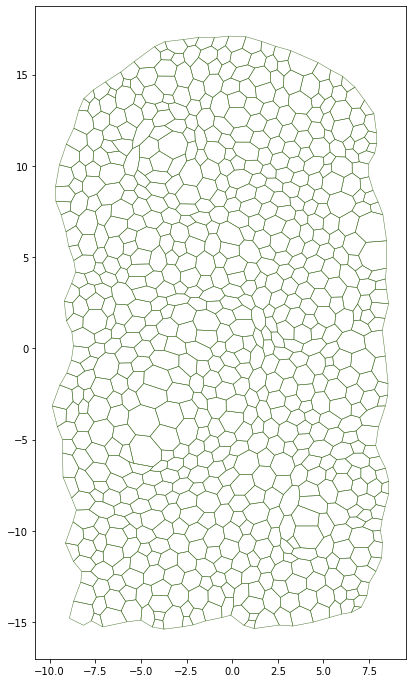

In [59]:
### divide all T cell areas

for numFace in range(len(cellmap_T.face_df)):
    mother = numFace
    daughter = cell_division(cellmap_T, mother, geom_T, angle=np.pi/2)
    if numFace in ten_random_faces:
        cellmap_T.face_df.loc[numFace, "prefered_area"] /= 4
        cellmap_T.face_df.loc [daughter, "prefered_area"] /= 4
    else:
        cellmap_T.face_df.loc[numFace, "prefered_area"] /= 2
        cellmap_T.face_df.loc [daughter, "prefered_area"] /= 2
    
        
    solver = QSSolver()
    res = solver.find_energy_min(cellmap_T, geom_T, model_T)
        
    #print(res['success'])
        



        

cellmap_D = cellmap_T
geom_D = geom_T
model_D = model_T
history_D = history_T

fig, ax = sheet_view(cellmap_D)
fig.set_size_inches(12, 12)

False
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True


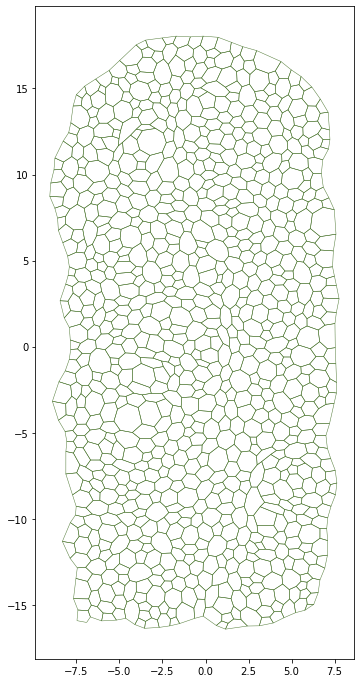

In [60]:
for numFace in range(len(cellmap_T.face_df)):
    if numFace in ten_random_faces.index or numFace in longest_eighty_percent:
        #print(numFace)
        mother = numFace
        daughter = cell_division(cellmap_T, mother, geom_T, angle=np.pi/2)
        cellmap_T.face_df.loc[numFace, "prefered_area"] /= 2
        cellmap_T.face_df.loc [daughter, "prefered_area"] /= 2
        
        solver = QSSolver()
        res = solver.find_energy_min(cellmap_T, geom_T, model_T)
        
        print(res['success'])
        



        

cellmap_D = cellmap_T
geom_D = geom_T
model_D = model_T
history_D = history_T

fig, ax = sheet_view(cellmap_D)
fig.set_size_inches(12, 12)

0.5766286876204021

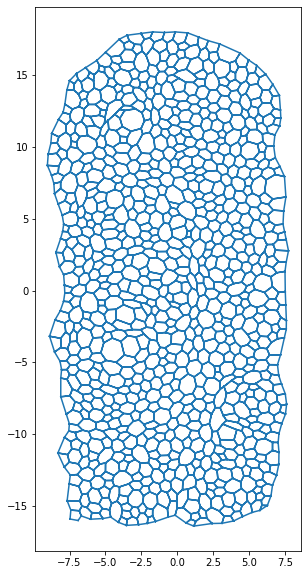

In [61]:
fig, ax = sheet_view(cellmap_D, mode="quick")

fig.set_size_inches(10, 10)
cellmap_D.face_df['area'].mean()
#plt.savefig('cellmap_T_cell_expansion.png')

In [62]:
cellmap_D.face_df['area'].mean()

0.5766286876204021

In [63]:
len(cellmap_D.face_df)*cellmap_D.face_df['area'].mean()

502.8202156049906

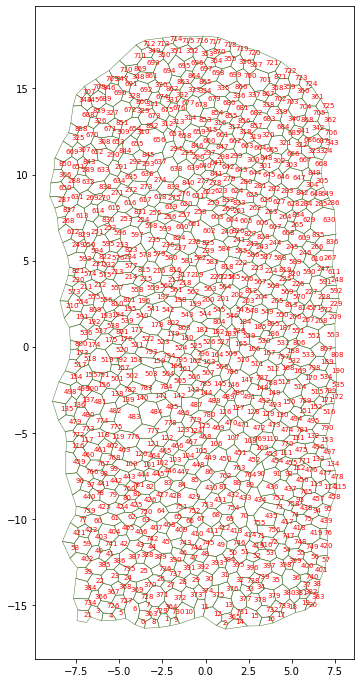

In [107]:
fig, ax = sheet_view(cellmap_D, ['x', 'y'])
fig.set_size_inches(12, 12)

for face, data in cellmap_D.face_df.iterrows():
    ax.text(data.x, data.y, face, fontsize=7, color="r")

In [46]:
#fig, ax = sheet_view(cellmap_T)
#fig.set_size_inches(15, 15)


#for edge, data in cellmap_T.edge_df.iterrows():
#    ax.text((data.sx+data.tx)/2, (data.sy + data.ty)/2, edge, color="blue")